# Exercise 3: Advanced Information Retrieval


## 1.  Introducing Word Embeddings

In this exercise, we would train word embeddings using a state-of-the-art embeddings library fastText. The first step of the exercise is to install the fasttext library. Proceed with the following steps:

### FastText installation

> pip install fasttext

If you are having problems, try this command:
> sudo apt-get install g++

In [1]:
!pip install fasttext

     |████████████████████████████████| 57 kB 1.2 MB/s eta 0:00:01
  Created wheel for fasttext: filename=fasttext-0.9.1-cp38-cp38-macosx_10_15_x86_64.whl size=275355 sha256=5be558b90329fa29f01033ae6feb4ce36315f3c0531a6d370de9c8c161c28499
  Stored in directory: /Users/giordanocolombi/Library/Caches/pip/wheels/70/de/57/385baa787dcec2e40c736288c39706cad2222e3c6027476128
Successfully built fasttext


### Generate Embeddings

In [2]:
import fasttext
import numpy as np

In [3]:
model = fasttext.train_unsupervised('epfldocs.txt', model = 'cbow')
vocabulary = model.words
word_embeddings = np.array([model[word] for word in vocabulary])

### Use Pretrained Embeddings
If you are unable to install fasttext, you can use the preembeddings we provide.

In [ ]:
import sys
import codecs
import numpy as np

# Edit this, or just move model_epfldocs.vec to the directory where this notebook is situated
directory_path = './'

def load_embeddings(file_name):
    with codecs.open(file_name, 'r', 'utf-8') as f_in:
        lines = f_in.readlines()
        lines = lines[1:]
        vocabulary, wv = zip(*[line.strip().split(' ', 1) for line in lines])
    wv = np.loadtxt(wv)
    return wv, vocabulary


# Replace the path based on your own machine.
word_embeddings, vocabulary = load_embeddings(directory_path + 'model_epfldocs.vec')

In [6]:
word_embeddings

array([[ 1.77262530e-01,  6.74905181e-02,  1.13667054e-02, ...,
        -6.36543155e-01, -4.08236653e-01, -2.30437759e-02],
       [ 1.43750682e-01,  4.60273176e-02,  1.46876266e-02, ...,
        -5.04118085e-01, -3.15162688e-01, -1.51901664e-02],
       [ 2.05331594e-01,  6.63510114e-02,  1.79085210e-02, ...,
        -7.01099038e-01, -4.33557391e-01, -2.22788677e-02],
       ...,
       [ 5.18627763e-02,  1.58437788e-02,  8.43447167e-03, ...,
        -1.82865739e-01, -1.15119405e-01, -2.45153974e-03],
       [ 5.60185015e-02,  1.99576076e-02,  5.12382342e-03, ...,
        -2.04041585e-01, -1.26813620e-01, -4.36559692e-03],
       [ 4.80018370e-02,  1.88445263e-02,  2.35011359e-03, ...,
        -1.62343934e-01, -1.01935379e-01,  2.28761273e-04]], dtype=float32)




### Visualize Embeddings

In the third phase of this exercise, we will visualize the generated embeddings using t-SNE (T-Distributed Stochastic Neighbouring Entities). t-SNE is a dimensionality reduction algorithm which is well suited for such visualization tasks.


In [4]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
import logging

tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, init = 'pca') 
vis_data = tsne.fit_transform(word_embeddings)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 432 samples in 0.001s...
[t-SNE] Computed neighbors for 432 samples in 0.035s...
[t-SNE] Computed conditional probabilities for sample 432 / 432
[t-SNE] Mean sigma: 0.072708
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.252357
[t-SNE] KL divergence after 950 iterations: 0.118320


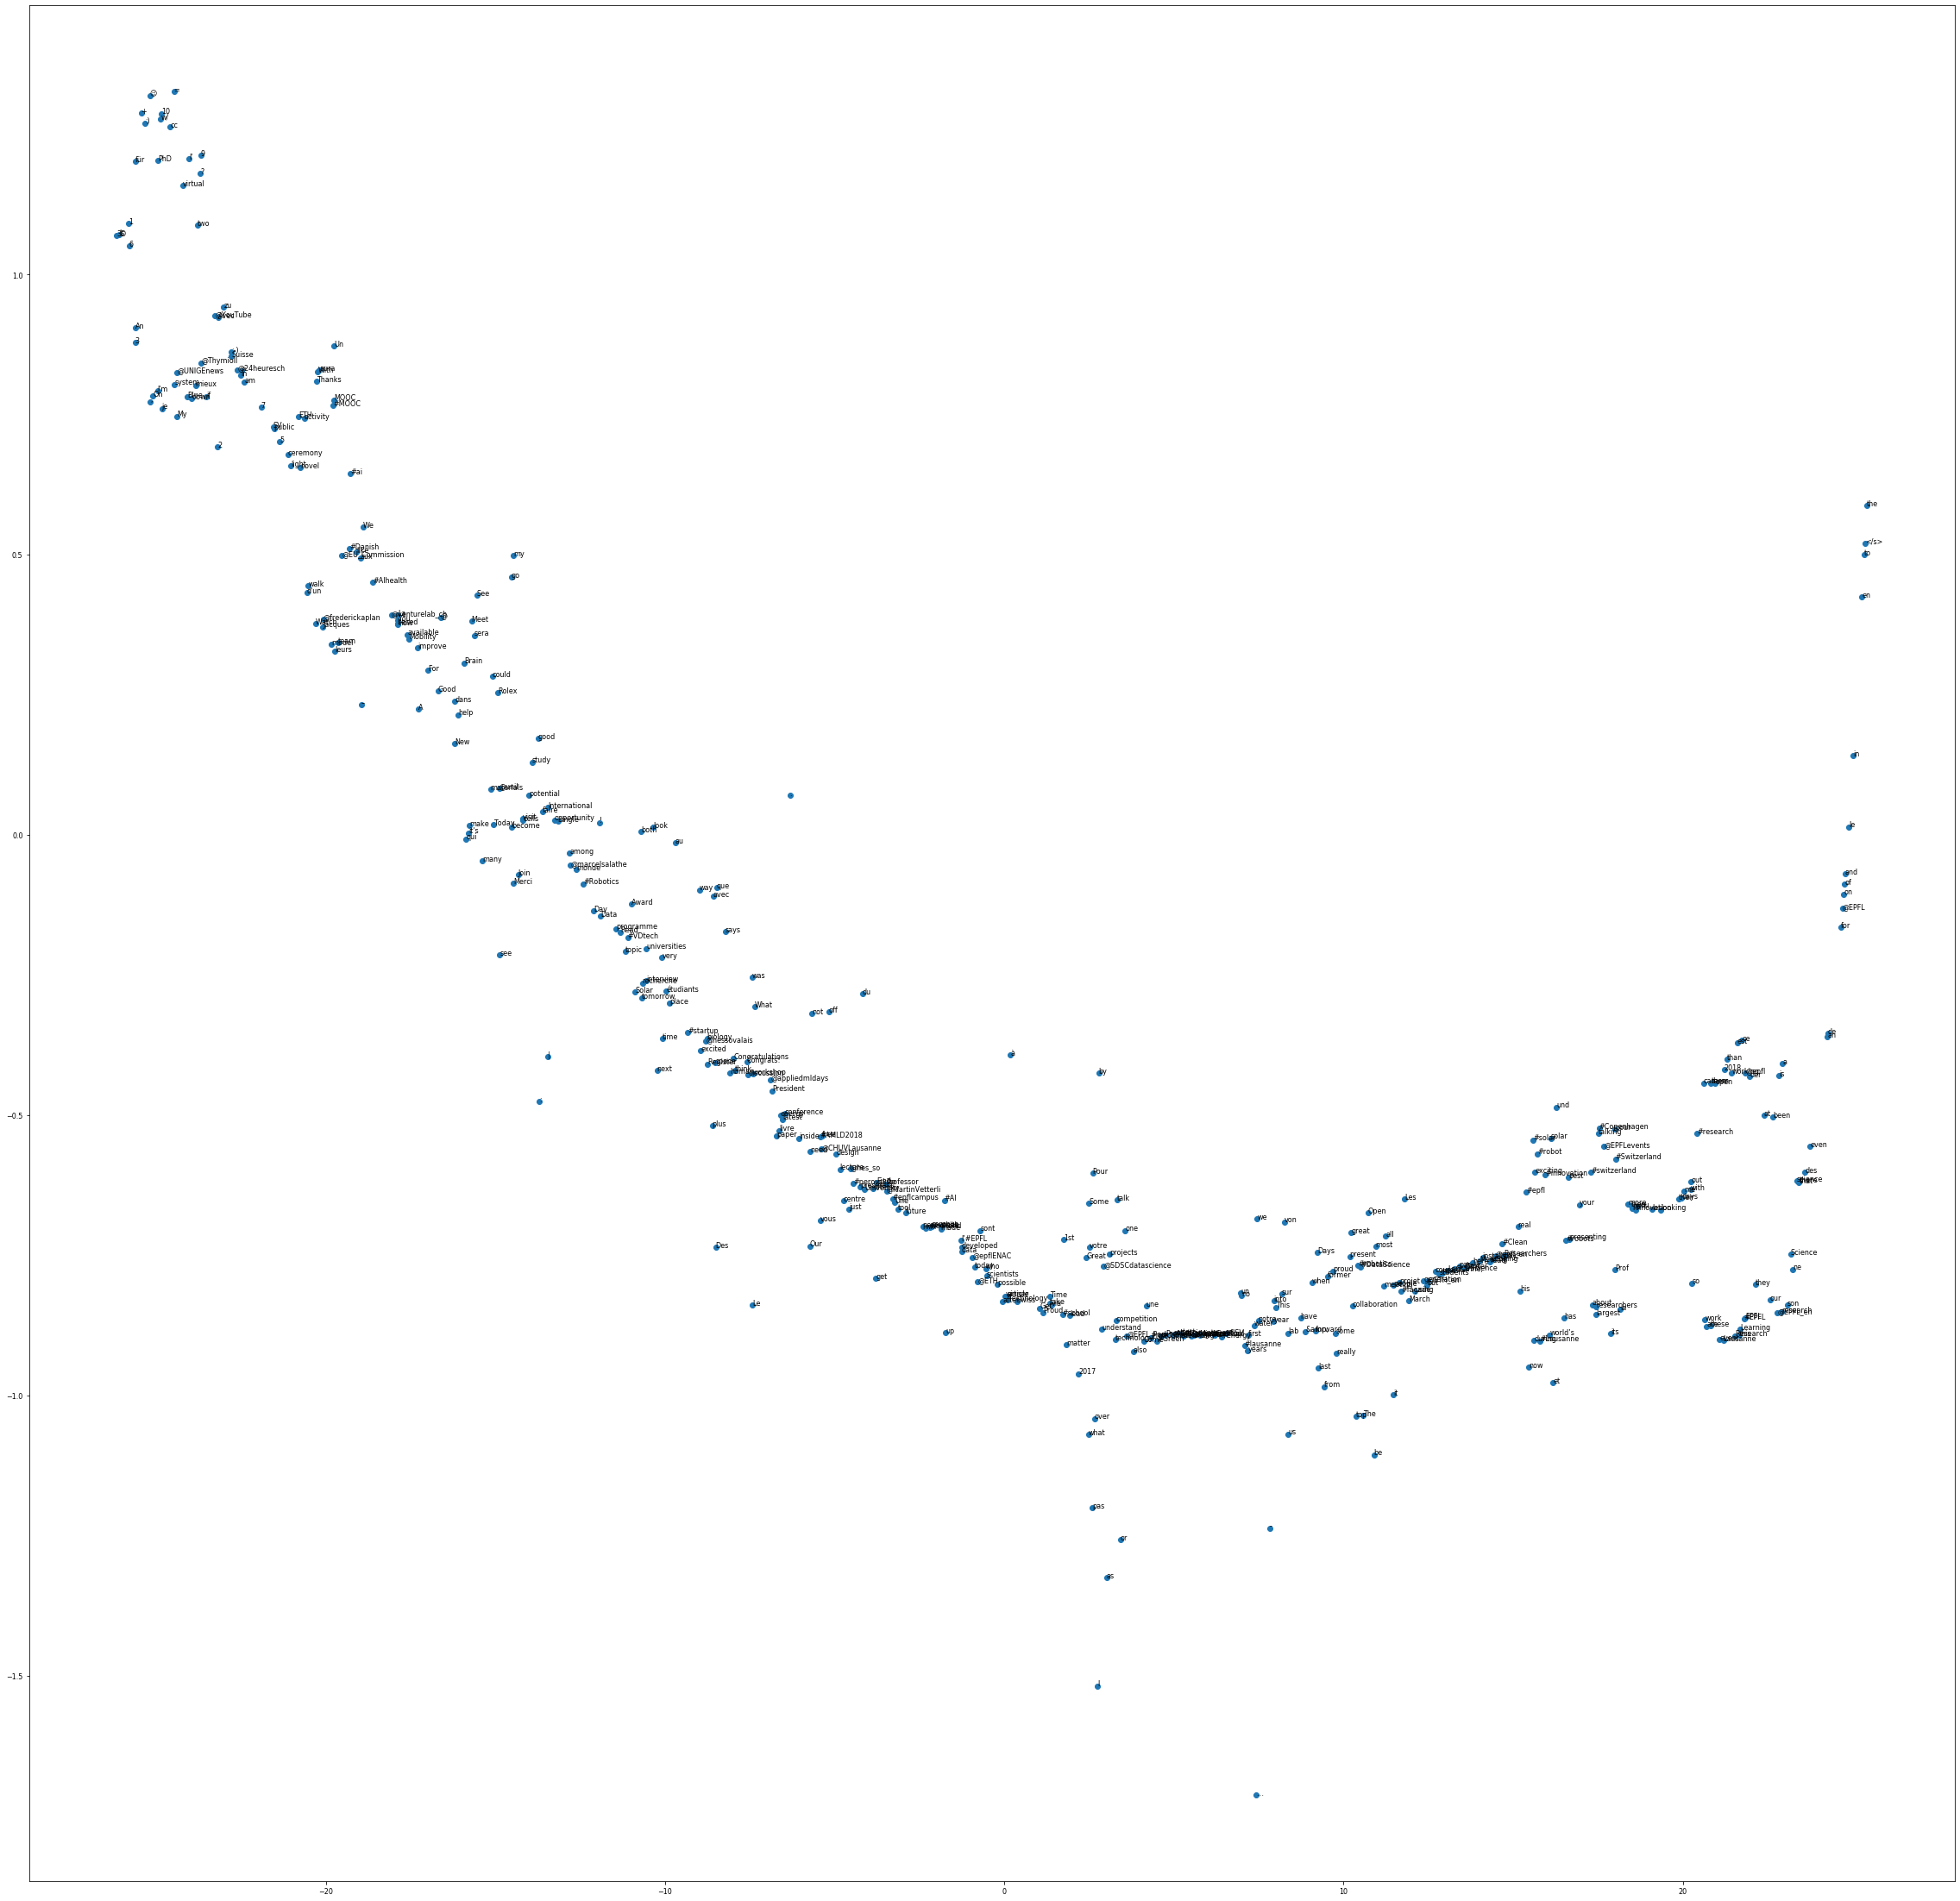

In [5]:
vis_data_x = vis_data[:,0]
vis_data_y = vis_data[:,1]

plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(40, 40)) 
plt.scatter(vis_data_x, vis_data_y)

for label, x, y in zip(vocabulary, vis_data_x, vis_data_y):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.show()

### Question 1. a

Observe the plot of word embeddings. Do you observe any patterns?



### Question 1. b

Write a python function to find the most similar terms for a given term. The similarity between two terms is defined as the cosine similarity between their corresponding word embeddings.

Find the top 5 terms that are most similar to 'la', 'EPFL', '#robot', 'this', 

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
import operator

def find_most_similar(input_term, word_embeddings, vocabulary, num_terms=5):
    terms_embedding_dict = {}
    for ix, word in enumerate(vocabulary):
            terms_embedding_dict[word] = word_embeddings[ix]
    scores = []
    if word not in vocabulary:
        return "word not in vocabulary"
    input_t = terms_embedding_dict[input_term]
    for word in terms_embedding_dict:
        scores.append((word, cosine_similarity(input_t.reshape(1, -1), terms_embedding_dict[word].reshape(1, -1))))
    
    #scores.sort(key = operator.itemgetter(1), reverse = True)
    sorted_terms = sorted(scores, key = lambda x: -1 * x[1])[0:num_terms]
    return sorted_terms
find_most_similar('EPFL', word_embeddings, vocabulary, num_terms=5)

[('EPFL', array([[1.]], dtype=float32)),
 ('@EPFL', array([[0.999979]], dtype=float32)),
 ('@EPFL_en', array([[0.99997365]], dtype=float32)),
 ('#EPFL', array([[0.9999731]], dtype=float32)),
 ('@EPFLevents', array([[0.9999715]], dtype=float32))]

### Question 1. c [Optional]
​
Observe the word embeddings that are visualized in this link http://www.anthonygarvan.com/wordgalaxy/ . Can you make some interesting observations? 

## 2.  Basic Search Engine Using Word Embeddings



In this exercise, we would put our word embeddings to test by using them for information retrieval. 
The idea is that, the documents that have the most similar embedding vectors to the one belongs to query should rank higher.
The documents may not necessarily include the keywords in the query.



In [18]:
# Loading of libraries and documents
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import string
import math
from collections import Counter

# Read a list of documents from a file. Each line in a file is a document
with open("epfldocs.txt", ) as f:
    content = f.readlines()
        
original_documents = [x.strip() for x in content] 

### Question 2. a
Since both the documents and the query is of variable size, we should aggregate the vectors of the words in the query by some strategy. This could be taking the minimum vector, maximum vector or the mean. Fill in the code below.

In [28]:
# Create a dictionary of vectors for easier search
vector_dict = dict(zip(vocabulary, word_embeddings))

def aggregate_vector_list(vlist, aggfunc):
    if aggfunc == 'max':
        return np.array(vlist).max(axis=0) # it keeps the max in each column
    elif aggfunc == 'min':
        return np.array(vlist).min(axis=0)
    elif aggfunc == 'mean':
        return np.array(vlist).mean(axis=0)
    else:
        return np.zeros(np.array(vlist).shape[1])

possible_aggfuncs = ["max", "min", "mean"]

aggregated_doc_vectors = {}

# Aggregate vectors of documents beforehand
# TODO
for aggfunc in possible_aggfuncs:
    aggregated_doc_vectors[aggfunc] = np.zeros((len(original_documents), word_embeddings.shape[1]))
    for index, doc in enumerate(original_documents):
        vlist = [vector_dict[token] for token in fasttext.tokenize(doc) if token in vector_dict]
        if len(vlist) < 1:
            continue
        else:
            aggregated_doc_vectors[aggfunc][index] = aggregate_vector_list(vlist, aggfunc)

### Question 2. b
Aggregate the query and find the most similar documents using cosine distance between the query's vector and document's aggregated vector. Are they seem to relevant?

In [30]:
word_embeddings.shape

(432, 100)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

query = "EPFL"

def aggregate_query(query, aggfunc):
    qlist = [vector_dict[token] for token in fasttext.tokenize(q) if token in vector_dict]
    if len(qlist) == 0
        return "no words in the query"
    else:
        return aggregate_vector_list()
    # TODO
    # Raise an error message for the case when there is no words in the query that is included in the vocabulary
    # This should return a vector of shape (1, word_embeddings.shape[1])
    
def get_most_similar_documents(query_vector, aggfunc, k = 5):
    # Calculate the similarity with each document vector. 
    # Hint: Cosine similarity function takes a matrix as input so you do not need to loop through each document vector.
    sim = # TODO
    
    # Rank the document vectors according to their cosine similarity with the query vector and return topk indexes
    indexes = # TODO

    return indexes


def search_vec_embeddings(query, topk = 10, aggfunc = 'mean'):
    query_vector = aggregate_query(query, aggfunc)
    indexes = get_most_similar_documents(query_vector, aggfunc)
    # Print the top k documents
    indexes = indexes[0:topk]
    for index in indexes:
        print(original_documents[index])

In [ ]:
search_vec_embeddings('EPFL', aggfunc = 'mean')

### Question 2. c
Compare the results with the vector space retrieval.


In [ ]:
# VECTOR SPACE RETRIEVAL (From Exercise 1)
# Retrieval oracle 
from operator import itemgetter
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 1, stop_words = 'english')
features = tf.fit_transform(original_documents)
npm_tfidf = features.todense()

# Return all document ids that that have cosine similarity with the query larger than a threshold
def search_vec_sklearn(query, topk = 10, features = features, threshold=0.1):
    new_features = tf.transform([query])
    cosine_similarities = cosine_similarity(new_features, features).flatten()
    related_docs_indices, cos_sim_sorted = zip(*sorted(enumerate(cosine_similarities), key=itemgetter(1), 
                                                       reverse=True))
    doc_ids = []
    for i, cos_sim in enumerate(cos_sim_sorted):
        if cos_sim < threshold or i >= topk:
            break
        doc_ids.append(related_docs_indices[i])
    
    for index in doc_ids:
        print(original_documents[index])

In [ ]:
search_vec_embeddings('EPFL', aggfunc = 'mean')
print("---------------------------------")
search_vec_sklearn("EPFL")

### Question 2. d
You will realize that not all the words in your queries are in the vocabulary, so your queries fail to retrieve any documents. Think of possible solutions to overcome this problem.